In [ ]:
!pip install torch --quiet
!pip install pandas --quiet
!pip install scikit-learn --quiet
!pip install rouge-score --quiet
!pip install seaborn --quiet
!pip install ipywidgets --quiet
!pip install tqdm --quiet
!pip install wandb --quiet

In [2]:
from torch import nn, Tensor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score 
from rouge_score import rouge_scorer 
from scipy.stats import zscore 
from tqdm.notebook import tqdm 
import seaborn as sns
from utils import *
from ROUGE_Score_Model import Model

___

In [3]:
def get_prompt(summary, prompts_df):
    return prompts_df.loc[prompts_df.prompt_id == summary.prompt_id].iloc[0]

In [4]:
def calc_rouge_scores(summaries_df, prompts_df):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    
    merged_df = prompts_df.merge(summaries_df, on='prompt_id', how='inner')

    for index, row in tqdm(merged_df.iterrows(), total=len(merged_df)):
        prompt_text = row['prompt_text']
        summary_text = row['text']
    
        scores = scorer.score(prompt_text, summary_text)
    
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    merged_df['rouge1_score'] = rouge1_scores
    merged_df['rouge2_score'] = rouge2_scores
    merged_df['rougeL_score'] = rougeL_scores

    return merged_df[[*summaries_df.columns.values, 'rouge1_score', 'rouge2_score', 'rougeL_score']]

## Setup

In [6]:
KEY = None

In [8]:
device, path = setup(wandb_key=KEY)
summaries_df, prompts_df = get_data('../kaggle/input/commonlit-evaluate-student-summaries')

GPU not available, CPU used


## Correlation Matrix

In [9]:
df = calc_rouge_scores(summaries_df, prompts_df)
df.loc[:, 'text_length'] = df['text'].apply(len)
df.loc[:, 'text_length_zscore'] = zscore(df['text_length'])

  0%|          | 0/5732 [00:00<?, ?it/s]

In [10]:
corr_matrix = df[['content',
                  'wording',
                  'rouge1_score',
                  'rouge2_score',
                  'rougeL_score',
                  'text_length_zscore'
                 ]].corr()

<Axes: >

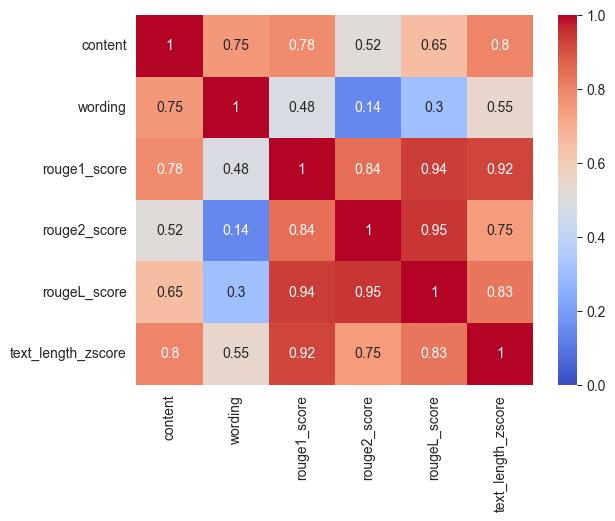

In [11]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)

## Set up Data (1)
**Stratified Split**

In [12]:
train_df, test_df = train_test_split(summaries_df, test_size=0.2, stratify=summaries_df["prompt_id"], random_state=42)

In [13]:
text_len_mean = train_df.text.apply(len).mean()
text_len_std  = train_df.text.apply(len).std()

In [14]:
epochs = 10
learning_rate = 0.01
hidden_dim = 64
output_dim = 1

In [15]:
model = Model(hidden_dim, output_dim, text_len_mean, text_len_std).to(device)

In [16]:
criterion = nn.MSELoss()
optimizer=torch.optim.Adam

In [17]:
optimizer = optimizer(list(model.parameters()))
optimizer.lr = learning_rate

## Training Model

In [18]:
project = "ESS_4"
name = "ROUGE_1"
notes = "Trained on all four topics"

architecture = "ROUGE"

In [19]:
wandb.init(
    project=project,
    name=name,
    notes=notes,
            
    # track hyperparameters and run metadata
    config={
        "architecture": architecture,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "loss_function":type(criterion),
        "optimizer":type(optimizer),
        "hidden_dim":hidden_dim,
        "non-lin":model.non_lin
        },
)

wandb: Currently logged in as: josef-rittiner. Use `wandb login --relogin` to force relogin


In [20]:
losses = []
mse = None
r2 = None
mse_test = None
r2_test = None

In [21]:
for epoch in tqdm(range(epochs), position=0):
    
    y_true = []
    y_pred = []
    
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    
    for index, summary in tqdm(train_df.iterrows(), total=len(train_df), position=1, leave=False, desc="Training"):
        
        prompt = get_prompt(summary, prompts_df)
        
        target = Tensor([summary.content]).to(device)
        #target = Tensor([summary.content, summary.wording]).to(device)

        predictions = model(prompt.prompt_text, summary.text)
        loss = criterion(predictions, target)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

        wandb.log({"loss": loss})
        losses.append(float(loss.item()))
        y_true.append(target.item())
        y_pred.append(predictions.item())

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    wandb.log({"MSE": mse, "R2": r2})

    y_true = []
    y_pred = []
    
    for index, summary in tqdm(test_df.iterrows(), total=len(test_df), position=1, leave=False, desc="Testing"):
        prompt = get_prompt(summary, prompts_df)
        
        target = Tensor([summary.content]).to(device)
        #target = Tensor([summary.content, summary.wording]).to(device)

        predictions = model(prompt.prompt_text, summary.text)
        
        y_true.append(target.item())
        y_pred.append(predictions.item())

    mse_test = mean_squared_error(y_true, y_pred)
    r2_test = r2_score(y_true, y_pred)
    wandb.log({"MSE_test": mse_test, "R2_test": r2_test})

wandb.log({"Final_MSE": mse, "Final_R2": r2})
wandb.log({"Test_MSE": mse_test, "Test_R2": r2_test})
wandb.finish()

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/4585 [00:00<?, ?it/s]

Testing:   0%|          | 0/1147 [00:00<?, ?it/s]

Training:   0%|          | 0/4585 [00:00<?, ?it/s]

Testing:   0%|          | 0/1147 [00:00<?, ?it/s]

Training:   0%|          | 0/4585 [00:00<?, ?it/s]

Testing:   0%|          | 0/1147 [00:00<?, ?it/s]

Training:   0%|          | 0/4585 [00:00<?, ?it/s]

Testing:   0%|          | 0/1147 [00:00<?, ?it/s]

Training:   0%|          | 0/4585 [00:00<?, ?it/s]

Testing:   0%|          | 0/1147 [00:00<?, ?it/s]

Training:   0%|          | 0/4585 [00:00<?, ?it/s]

Testing:   0%|          | 0/1147 [00:00<?, ?it/s]

Training:   0%|          | 0/4585 [00:00<?, ?it/s]

Testing:   0%|          | 0/1147 [00:00<?, ?it/s]

Training:   0%|          | 0/4585 [00:00<?, ?it/s]

Testing:   0%|          | 0/1147 [00:00<?, ?it/s]

Training:   0%|          | 0/4585 [00:00<?, ?it/s]

Testing:   0%|          | 0/1147 [00:00<?, ?it/s]

Training:   0%|          | 0/4585 [00:00<?, ?it/s]

Testing:   0%|          | 0/1147 [00:00<?, ?it/s]

Final_MSE,▁
Final_R2,▁
MSE,█▃▂▂▂▁▁▁▁▁
MSE_test,██▃▄▃▃▆▂▂▁
R2,▁▆▇▇▇█████
R2_test,▁▁▆▅▆▆▃▇▇█
Test_MSE,▁
Test_R2,▁
loss,▂▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▄▁▁▁▁▂▁▁▂▁▁▂▁▂▁▁▁▁█▁▁▂▁
Final_MSE,0.24097
Final_R2,0.77333


In [22]:
print(f"MSE Validation Set: {mse_test:.4f}")
print(f"R2 Validation Set:  {r2_test:.4f}")

MSE Validation Set: 0.2067
R2 Validation Set:  0.8249


In [23]:
torch.save(model.state_dict(), f"models/ROUGE/{name}.pt")

## Set up Data (2)
**Training on three, testing on one Topic**

In [24]:
min_prompt_id = summaries_df['prompt_id'].value_counts().idxmin()
print(prompts_df.loc[prompts_df.prompt_id == min_prompt_id].prompt_title)

2    The Third Wave
Name: prompt_title, dtype: object


In [25]:
test_df = summaries_df[summaries_df['prompt_id'] == min_prompt_id]
train_df = summaries_df[summaries_df['prompt_id'] != min_prompt_id]

In [26]:
text_len_mean = train_df.text.apply(len).mean()
text_len_std  = train_df.text.apply(len).std()

In [27]:
epochs = epochs
learning_rate = learning_rate
hidden_dim = hidden_dim
output_dim = output_dim

In [28]:
model = Model(hidden_dim, output_dim, text_len_mean, text_len_std).to(device)

In [29]:
criterion = nn.MSELoss()
optimizer=torch.optim.Adam

In [30]:
optimizer = optimizer(list(model.parameters()))
optimizer.lr = learning_rate

## Training Model

In [31]:
project = project
name = "ROUGE_2"
notes = "Trained on three topics\ntested on fourth"

architecture = architecture

In [32]:
wandb.init(
    project=project,
    name=name,
    notes=notes,
            
    # track hyperparameters and run metadata
    config={
        "architecture": architecture,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "loss_function":type(criterion),
        "optimizer":type(optimizer),
        "hidden_dim":hidden_dim,
        "non-lin":model.non_lin
        },
)

In [33]:
losses = []

In [34]:
for epoch in tqdm(range(epochs), position=0):
    
    y_true = []
    y_pred = []
    
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    
    for index, summary in tqdm(train_df.iterrows(), total=len(train_df), position=1, leave=False, desc="Training"):
        
        prompt = get_prompt(summary, prompts_df)
        
        target = Tensor([summary.content]).to(device)
        #target = Tensor([summary.content, summary.wording]).to(device)

        predictions = model(prompt.prompt_text, summary.text)
        loss = criterion(predictions, target)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

        wandb.log({"loss": loss})
        losses.append(float(loss.item()))
        y_true.append(target.item())
        y_pred.append(predictions.item())

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    wandb.log({"MSE": mse, "R2": r2})

    y_true = []
    y_pred = []
    
    for index, summary in tqdm(test_df.iterrows(), total=len(test_df), position=1, leave=False, desc="Testing"):
        prompt = get_prompt(summary, prompts_df)
        
        target = Tensor([summary.content]).to(device)
        #target = Tensor([summary.content, summary.wording]).to(device)

        predictions = model(prompt.prompt_text, summary.text)
        
        y_true.append(target.item())
        y_pred.append(predictions.item())

    mse_test = mean_squared_error(y_true, y_pred)
    r2_test = r2_score(y_true, y_pred)
    wandb.log({"MSE_test": mse_test, "R2_test": r2_test})

wandb.log({"Final_MSE": mse, "Final_R2": r2})
wandb.log({"Test_MSE": mse_test, "Test_R2": r2_test})
wandb.finish()

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Testing:   0%|          | 0/882 [00:00<?, ?it/s]

Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Testing:   0%|          | 0/882 [00:00<?, ?it/s]

Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Testing:   0%|          | 0/882 [00:00<?, ?it/s]

Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Testing:   0%|          | 0/882 [00:00<?, ?it/s]

Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Testing:   0%|          | 0/882 [00:00<?, ?it/s]

Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Testing:   0%|          | 0/882 [00:00<?, ?it/s]

Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Testing:   0%|          | 0/882 [00:00<?, ?it/s]

Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Testing:   0%|          | 0/882 [00:00<?, ?it/s]

Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Testing:   0%|          | 0/882 [00:00<?, ?it/s]

Training:   0%|          | 0/4850 [00:00<?, ?it/s]

Testing:   0%|          | 0/882 [00:00<?, ?it/s]

Final_MSE,▁
Final_R2,▁
MSE,█▃▃▂▂▂▁▁▁▁
MSE_test,█▂▂▃▂█▂▁▁▅
R2,▁▆▆▇▇▇████
R2_test,▁▇▇▆▇▁▇██▄
Test_MSE,▁
Test_R2,▁
loss,▄▁▃▁▁▂▃▂▃▁▄▁▃▁█▁▄▂▁▁▁▁▁▁▃▁▂▁▁▂▂▁▂▄▁▄▁▁▁▁
Final_MSE,0.22081
Final_R2,0.79097


In [35]:
print(f"MSE Validation Set: {mse_test:.4f}")
print(f"R2 Validation Set:  {r2_test:.4f}")

MSE Validation Set: 0.3138
R2 Validation Set:  0.7429


In [36]:
torch.save(model.state_dict(), f"models/ROUGE/{name}.pt")